In [6]:
import os
import sys
import glob
import itertools

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

np.random.seed(1234)

%matplotlib inline

# Load AML data

In [2]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)

print table
print X.shape

                        CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  \
Basophils                  0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   
CD4 T cells                0.0    0.0    -1   0.0    0.0  1.0 -1.0    -1   
CD8 T cells                0.0    0.0    -1   0.0    0.0 -1.0  1.0    -1   
CD16- NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD16+ NK cells             0.0    0.0    -1   0.0    0.0  0.0  0.0    -1   
CD34+CD38+CD123- HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38+CD123+ HSPCs     0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
CD34+CD38lo HSCs           0.0    0.0    -1   0.0    0.0  0.0 -1.0     1   
Mature B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Plasma B cells             0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pre B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   
Pro B cells                0.0    0.0     1   0.0    0.0  0.0 -1.0     1   
Monocytes   

Explore a little bit about properties of arcsinh...

44.4422639474


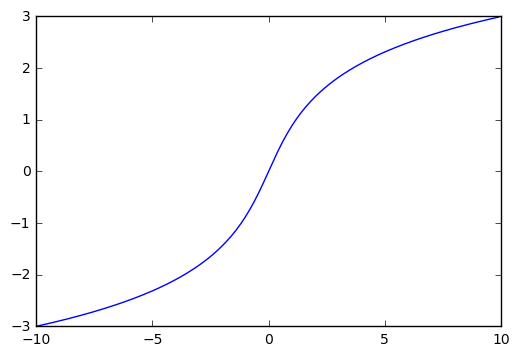

In [3]:
t1 = np.arange(-10.0, 10.0, 0.1)
t2 = np.arcsinh(t1)
plt.plot(t1,t2)

print np.arcsinh(10000000000000000000)

# Draw cuts with prior information
Data is now in a D dimensional cube, the goal it to find one optimal cut in each dimension

In [4]:
def draw_informed_cuts(theta_space, table):
    """
    INPUT: table: a K*D DataFrame of +-1 knowledge
    OUTPUT: np.array of lenght D, cuts on each dimension 
    """
    # return a list of cuts 
    # INFORMATIVE PRIORS
    upper_cut = (5., 1.)
    lower_cut = (1., 5.)
    middle_cut = (5., 5.)
    neutral_cut = (1., 1.)
    priors_dict = { '-1':lower_cut, '0':neutral_cut, '1':upper_cut, 
                   '-1 0':lower_cut, '-1 1':middle_cut, '0 1':upper_cut,
                   '-1 0 1': middle_cut
                  }
    
    headers = list(table)
    
    matching_prior_info = [np.unique(table[_]) for _ in headers]
    prior_type_str = [' '.join([str(int(x)) for x in _ ]) for _ in matching_prior_info]
    prior_params = [priors_dict[_] for _ in prior_type_str]
    
    
    cuts = [(theta_space[d,1] - theta_space[d,0]) * np.random.beta(prior_params[d][0], prior_params[d][1]) + theta_space[d,0] 
            for d in range(len(headers))]
    return cuts

In [5]:
def comp_log_p_sample(theta_space, data, cuts):
    D = len(cuts)
    
    if D == 0:
        return 0
    
    idx_left = data[:,0] < cuts[0]
    idx_right = data[:,0] >= cuts[0]
    log_len_left =  np.log(cuts[0] - theta_space[0,0])
    log_len_right = np.log(theta_space[0,1] - cuts[0])
    return - idx_left.sum() * log_len_left - idx_right.sum() * log_len_right +\
            comp_log_p_sample(theta_space[1:], data[:,1:],cuts[1:])

# Fit model to 2 dimensional data and visualize

In [7]:
data_2d = np.hstack([data[:,5][np.newaxis].T, data[:,6][np.newaxis].T])
np.random.shuffle(data_2d)
data_2d = data_2d[:1000,:]
table_2d = table[['CD4','CD8']]
print data_2d.shape

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()

theta_space = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space

(1000, 2)
[[-0.2538249   2.81347347]
 [-0.2532051   4.047951  ]]


In [8]:
n_mcmc_chain = 2
n_mcmc_sample = 30000
mcmc_gaussin_std = np.array([(_[1]-_[0])*0.01 for _ in theta_space]) # tune step size s.t. acceptance rate ~50%

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_cuts(theta_space, table_2d)
    log_p_sample = comp_log_p_sample(theta_space, data_2d, sample)
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        # propose a new sample under gaussian distribution
        good_sample = False
        while good_sample == False:
            new_sample = np.array([np.random.normal(0, mcmc_gaussin_std[d], 1)[0] for d in range(2)])  + sample
            if (new_sample > theta_space[:,0]).all() and (new_sample < theta_space[:,1]).all():
                good_sample = True
                
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(theta_space, data_2d, new_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
                sample = new_sample
                log_p_sample = new_log_p_sample
                accepts[chain].append(sample)
        

        if (idx+1) % 1000 == 0:
            print "Iteration %d, Samples %d" %(idx+1, len(accepts[chain]))

    print "Number of samples collected: %d" %(len(accepts[chain]))

Drawing Chain 0 ...
Iteration 1000, Samples 129
Iteration 2000, Samples 136
Iteration 3000, Samples 136
Iteration 4000, Samples 136
Iteration 5000, Samples 137
Iteration 6000, Samples 140
Iteration 7000, Samples 141
Iteration 8000, Samples 142
Iteration 9000, Samples 144
Iteration 10000, Samples 145
Iteration 11000, Samples 147
Iteration 12000, Samples 154
Iteration 13000, Samples 156
Iteration 14000, Samples 157
Iteration 15000, Samples 158
Iteration 16000, Samples 165
Iteration 17000, Samples 177
Iteration 18000, Samples 187
Iteration 19000, Samples 197
Iteration 20000, Samples 201
Iteration 21000, Samples 203
Iteration 22000, Samples 205
Iteration 23000, Samples 211
Iteration 24000, Samples 216
Iteration 25000, Samples 217
Iteration 26000, Samples 220
Iteration 27000, Samples 225
Iteration 28000, Samples 231
Iteration 29000, Samples 240
Iteration 30000, Samples 241
Number of samples collected: 241
Drawing Chain 1 ...
Iteration 1000, Samples 118
Iteration 2000, Samples 123
Iteration 

In [9]:
# get an average model
burnt_accepts = np.array([_ for chain in accepts for _ in chain[len(chain)/2:]])
avg_cuts = np.mean(burnt_accepts, axis=0)

to-do: burn-in and thinning ...

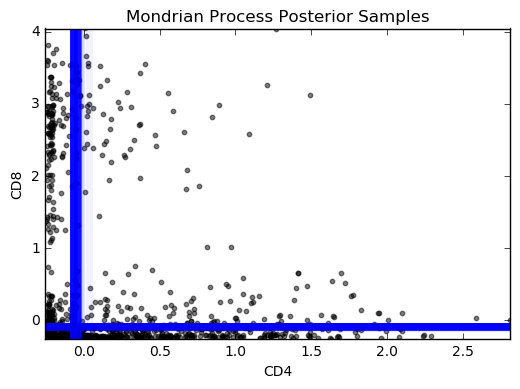

In [10]:
### VISUALIZE 2D POSTERIOR WITH DATA###
def print_posterior(theta_space, data, list_of_cuts , trans_level=.05, color='k'):
    plt.figure()    
    plt.scatter(data[:,0], data[:,1], c='k', edgecolors='k', s=10, alpha=.5)

    for cuts in list_of_cuts:
        plt.plot([cuts[0], cuts[0]], [theta_space[1,0], theta_space[1,1]], color+'-', linewidth=5, alpha=trans_level)  
        plt.plot([theta_space[0,0], theta_space[0,1]], [cuts[1], cuts[1]], color+'-', linewidth=5, alpha=trans_level)  

np.random.shuffle(burnt_accepts)
print_posterior(theta_space, data_2d, burnt_accepts[:100] , trans_level=.05, color='b')

plt.xlabel("CD4")
plt.ylabel("CD8")
plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

# Fit model to full AML data

In [11]:
print data.shape
N,D = data.shape

(104184, 32)


In [12]:
# input data: data, table
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])

In [14]:
%%time

n_mcmc_chain = 4
n_mcmc_sample = 10000
mcmc_gaussin_std = np.array([(_[1]-_[0])*0.01 for _ in theta_space]) # tune step size s.t. acceptance rate ~50%
batch_size = 5000

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    print "Drawing Chain %d ..." % chain
    
    sample = draw_informed_cuts(theta_space, table)
    log_p_sample = comp_log_p_sample(theta_space, data[np.random.choice(data.shape[0], size=batch_size,replace=False), :], sample)
    
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        # propose a new sample under gaussian distribution
        good_sample = False
        while good_sample == False:
            new_sample = np.array([np.random.normal(0, mcmc_gaussin_std[d], 1)[0] for d in range(D)])  + sample
            if (new_sample > theta_space[:,0]).all() and (new_sample < theta_space[:,1]).all():
                good_sample = True

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(theta_space, data[np.random.randint(data.shape[0], size=batch_size), :], new_sample)
        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
                sample = new_sample
                log_p_sample = new_log_p_sample
                accepts[chain].append(sample)
        

        if (idx+1) % 1000 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

Drawing Chain 0 ...
Iteration 1000, cummulative accepted sample size is 187
Iteration 2000, cummulative accepted sample size is 207
Iteration 3000, cummulative accepted sample size is 217
Iteration 4000, cummulative accepted sample size is 260
Iteration 5000, cummulative accepted sample size is 275
Iteration 6000, cummulative accepted sample size is 296
Iteration 7000, cummulative accepted sample size is 308
Iteration 8000, cummulative accepted sample size is 309
Iteration 9000, cummulative accepted sample size is 309
Iteration 10000, cummulative accepted sample size is 309
Drawing Chain 1 ...
Iteration 1000, cummulative accepted sample size is 126
Iteration 2000, cummulative accepted sample size is 216
Iteration 3000, cummulative accepted sample size is 260
Iteration 4000, cummulative accepted sample size is 260
Iteration 5000, cummulative accepted sample size is 260
Iteration 6000, cummulative accepted sample size is 260
Iteration 7000, cummulative accepted sample size is 260
Iterati

In [15]:
# get an average model
burnt_accepts = np.array([_ for chain in accepts for _ in chain[len(chain)*10/11:]])
avg_cuts = np.mean(burnt_accepts, axis=0)

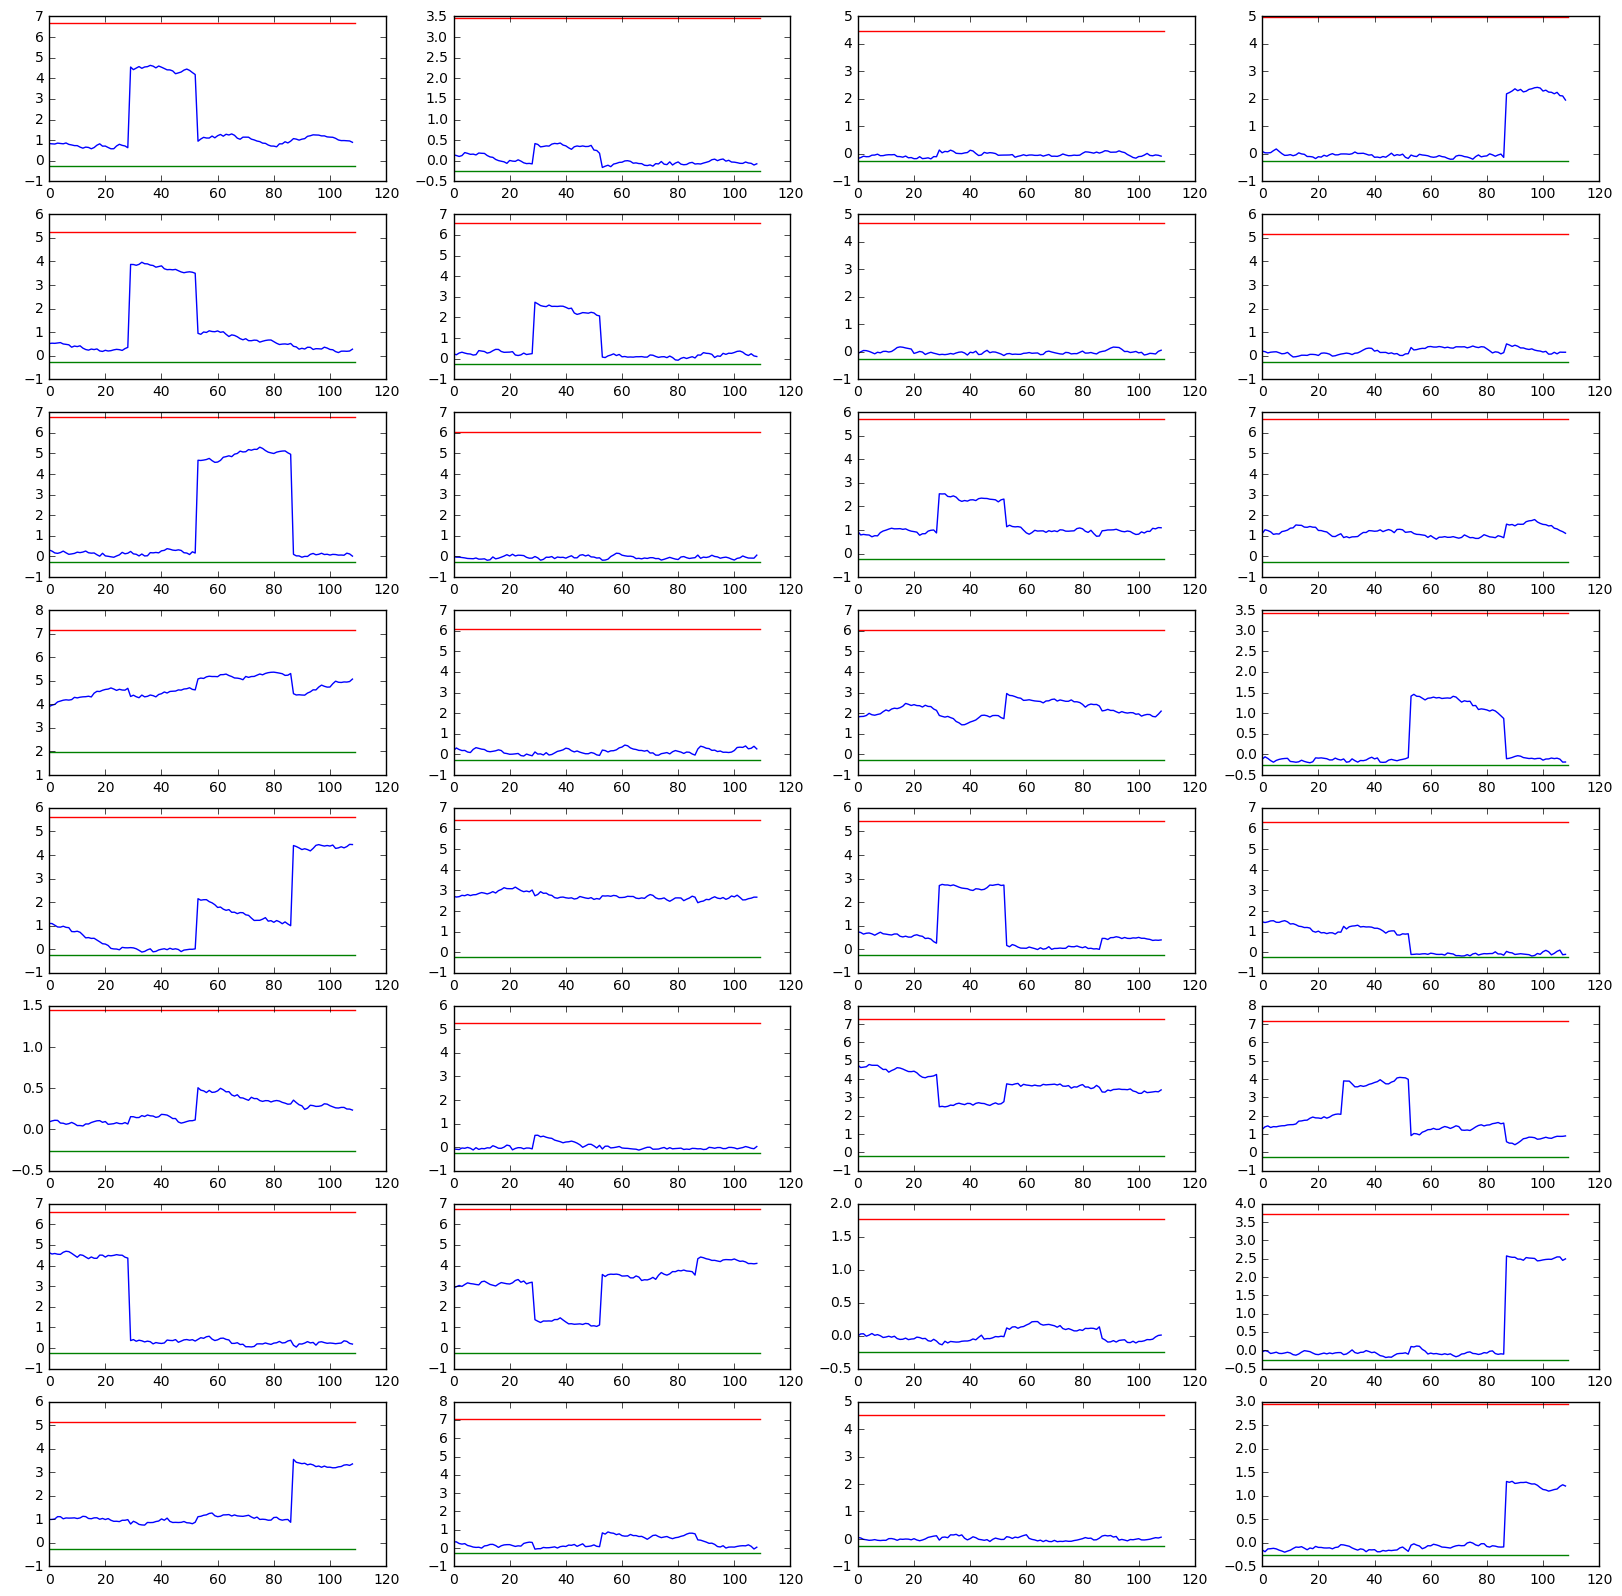

In [16]:
# plot trace of burnt_accepts
# Four axes, returned as a 2-d array
f, axarr = plt.subplots(D/4, 4,figsize=(20,20))
for _ in range(D):
    axarr[_/4, _%4].plot(burnt_accepts[:,_])
    axarr[_/4, _%4].plot([0,len(burnt_accepts)],[theta_space[_,0],theta_space[_,0]])
    axarr[_/4, _%4].plot([0,len(burnt_accepts)],[theta_space[_,1],theta_space[_,1]])

In [41]:
print table.iloc[[8,10,12]]

                CD45RA  CD133  CD19  CD22  CD11b  CD4  CD8  CD34  Flt3  CD20  \
Mature B cells     0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   
Pre B cells        0.0    0.0     1   0.0    0.0  0.0 -1.0    -1   0.0   0.0   
Monocytes          0.0    0.0    -1   0.0    0.0  0.0 -1.0    -1   0.0  -1.0   

                ...   CD44  CD38  CD13  CD3  CD61  CD117  CD49d  HLA-DR  CD64  \
Mature B cells  ...    0.0   0.0   0.0   -1   0.0    0.0    0.0     0.0   0.0   
Pre B cells     ...    0.0   1.0   0.0   -1   0.0    0.0    0.0     1.0  -1.0   
Monocytes       ...    0.0   0.0   0.0   -1   0.0    0.0    0.0     1.0   0.0   

                CD41  
Mature B cells   0.0  
Pre B cells      0.0  
Monocytes        0.0  

[3 rows x 32 columns]


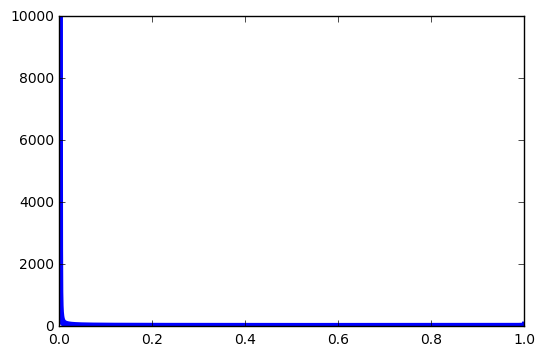

In [40]:
from math import *

def y(x):
    return  -(1.-pow(x,3)/3.)*log(x) - pow(x,3)/3*log(1-x)

x_lim = [i*1.0/10000 for i in range(1,10000)]
y = [exp(y(x)) for x in x_lim]
plt.plot(x_lim,y,linewidth=5)